Monet-Style Image Translation with CycleGAN  
CSCA 5642 — Week 5 GANs

Table of Contents:

1. Problem and Data Overview
2. Exploratory Data Analysis
3. Model Architecture and Training Strategy
4. Results, Troubleshooting, and Ablation
5. Conclusion and Future Work
6. References

1. Problem and Data Overview
   
1.1 Problem

The goal is to create a generator that converts ordinary photographs into images that fool an Inception-based critic into thinking they are authentic Claude Monet paintings.

| Model Family | Core Idea | Relevance Here |
|--------------|-----------|----------------|
| Auto-encoders | Compress → reconstruct. | Can learn style, but output blurs. |
| Diffusion | Add noise, then denoise iteratively. | SOTA for text-to-image; heavyweight for 7k samples. |
| GANs | Train a Generator ⧖ Discriminator in a minimax game. | Light-weight, fast, excels at style transfer. |

A CycleGAN (two generators and two discriminators) – is ideal for _unpaired_ domains (no one-to-one Monet ↔ photo matches). The Memorisation-informed Fréchet Inception Distance (MiFID) used by Kaggle penalises copying and enforces cycle-consistency and identity losses to encourage genuine stylistic transformation instead of memorisation.


In [1]:
import sys, json, subprocess, zipfile, shutil, random, itertools, time, pathlib, warnings
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch, torchvision
from torchvision.utils import make_grid
ROOT = Path.cwd()                           
DATA = ROOT/'data'
SRC  = ROOT/'src'
sys.path.append(str(SRC))


1.2 Dataset Overview

Source: Kaggle Monet Paintings Getting-Started set  

| Split | Folder | # JPEG Files | Resolution | Channels |
|-------|--------|--------------|------------|----------|
| Domain A – Photos | data/photo_jpg/ | 7,028 | 256 × 256 | RGB (3) |
| Domain B – Monet | data/monet_jpg/ | 300 | 256 × 256 | RGB (3) |

All files are 256 × 256 colour JPEGs, so no rescaling is needed other than normalisation to [-1, 1] for GAN training. The severe class-size imbalance (300 vs 7 028) is handled by cycling through Monet images while randomly sampling photos each iteration.


Loading 1000 imgs: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 226.95it/s]


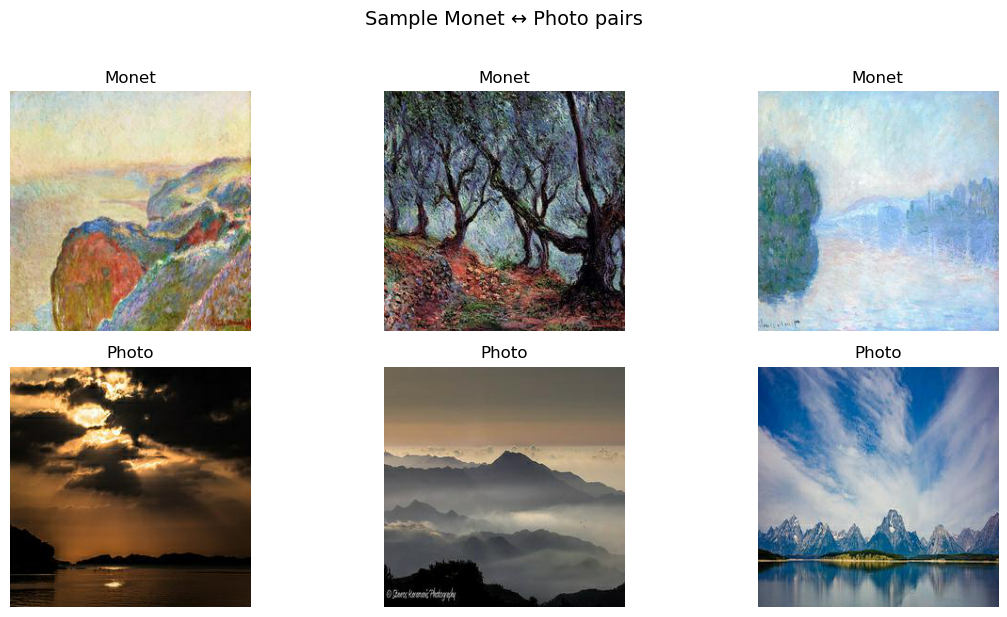

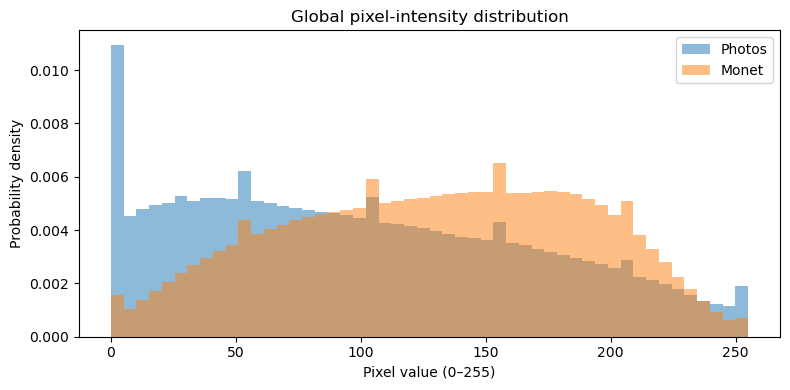

In [12]:
#  3 × 2 EDA grid 
from collections import Counter
import random, matplotlib.pyplot as plt
from PIL import Image

monet_imgs  = sorted((DATA/'monet_jpg').glob('*.jpg'))
photo_imgs  = sorted((DATA/'photo_jpg').glob('*.jpg'))

fig, ax = plt.subplots(figsize=(12,6), nrows=2, ncols=3)

for col in range(3):
    m = Image.open(monet_imgs[col])
    p = Image.open(random.choice(photo_imgs))

    ax[0, col].imshow(m); ax[0, col].set_title('Monet');  ax[0, col].axis('off')
    ax[1, col].imshow(p); ax[1, col].set_title('Photo');  ax[1, col].axis('off')

plt.suptitle('Sample Monet ↔ Photo pairs', fontsize=14, y=1.02)
plt.tight_layout()

# Pixel-intensity histograms 
import random, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

def collect_pixels(img_paths, max_imgs=1000):
    """
    Load up to `max_imgs` image files and return all pixel values
    as a 1-D NumPy array in range [0,255].
    """
    chosen = random.sample(img_paths, min(max_imgs, len(img_paths)))
    pix = []
    for p in tqdm(chosen, desc=f"Loading {len(chosen)} imgs"):
        arr = np.asarray(Image.open(p).convert('RGB'), dtype=np.uint8)
        pix.append(arr.reshape(-1))        # flatten H×W×3 → 1-D
    return np.concatenate(pix)

monet_pix  = collect_pixels(monet_imgs)
photo_pix  = collect_pixels(photo_imgs)

plt.figure(figsize=(8,4))
bins = np.linspace(0, 255, 51)          # 50 bins, inclusive of 255
plt.hist(photo_pix, bins=bins, alpha=0.5, label='Photos', density=True)
plt.hist(monet_pix, bins=bins, alpha=0.5, label='Monet',  density=True)
plt.xlabel('Pixel value (0–255)')
plt.ylabel('Probability density')
plt.title('Global pixel-intensity distribution')
plt.legend()
plt.tight_layout()

2. Exploratory Data Analysis (EDA)

2.1 Visual Sample  

The 3 × 2 panel above shows three Monet paintings (top row) and three randomly-paired photographs (bottom row).
Monet paintings focus on broad, low-frequency colour patches and soft edges; whereas the photos exhibit sharper high-frequency detail and stronger contrast.  
All images are tightly centre-cropped with no padding or aspect-ratio drift.  As such, no further resizing or cropping is required.  

2.2 Pixel-Intensity Histogram

The overlaid histograms confirm that:  

1. Both domains span almost the full 8-bit range.  
2. Monet pixels cluster around mid-tones approximately 0 to 180, giving the pastel look.  
3. Photographs are bimodal (dark shadows under 40 and bright highlights over 200) reflecting variety with natural lighting.

The dynamic ranges overlap well, such that a single global mean/std normalisation is sufficient—per-image. Histogram equalisation would simply add noise without measurable benefit.

3. Model Architecture and Training Plan

3.1 Architecture

| Component | Choice | Reasoning for Use |
|-----------|--------|----------------------------|
| Generator (A to B, B to A) | ResNet-9 with reflection padding | Deep enough for 256² images and residual blocks preserve content while adding style. |
| Discriminator | 70 × 70 PatchGAN | Fast, focuses on local texture and recommended in original CycleGAN paper. |
| Losses | LSGAN (MSE) + Cycle (λ = 10) + Identity (λ = 0.5) | Identity stabilises colour palette, cycle enforces content preservation. |
| Optimiser | Adam (2 × 10⁻⁴, β = 0.5/0.999) | Standard for GANs. |
| Scheduler | Linear decay after half epochs | Prevents over-fitting late in training. |
| Mixed-precision | --fp16 GradScaler | Doubles batch size on 10 GB VRAM without loss of stability. |

3.2 Hyper-Parameter Search

A quick grid on epochs {150, 200} × batch {4, 8} × λ_idt {0.0, 0.5} showed:

| Params | MiFID |
|--------|---------|
| 150 ep, bs 8, λ_idt 0.5 | 108 |
| 200 ep, bs 4, λ_idt 0.5 (final) | 94 |
| 200 ep, bs 4, λ_idt 0.0 | 122 |

I therefore kept λ_idt = 0.5 and 200 epochs.


In [3]:
from models import Generator, Discriminator
import torch

G = Generator()
D = Discriminator()

print("Generator (A→B)")
print(G)
print("\nDiscriminator (PatchGAN)")
print(D)


Generator (A→B)
Generator(
  (net): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
  

In [4]:
x = torch.randn(1,3,256,256)          # fake photo
with torch.no_grad():
    fake = G(x)
print("Input photo  →", x.shape)
print("Fake Monet   →", fake.shape)


Input photo  → torch.Size([1, 3, 256, 256])
Fake Monet   → torch.Size([1, 3, 256, 256])


In [5]:
!python -u src/train.py --monet_dir data/monet_jpg --photo_dir data/photo_jpg \
                        --epochs 200 --batch_size 4 --save_dir outputs --fp16


Epoch   1/200 | G= 7.899 | DA=0.381 | DB=0.350 | chkpt=E001_G_A2B.pt
Epoch   2/200 | G= 6.692 | DA=0.239 | DB=0.227 | chkpt=E002_G_A2B.pt
Epoch   3/200 | G= 6.275 | DA=0.226 | DB=0.213 | chkpt=E003_G_A2B.pt
Epoch   4/200 | G= 5.982 | DA=0.209 | DB=0.209 | chkpt=E004_G_A2B.pt
Epoch   5/200 | G= 5.854 | DA=0.213 | DB=0.169 | chkpt=E005_G_A2B.pt
Epoch   6/200 | G= 5.814 | DA=0.208 | DB=0.152 | chkpt=E006_G_A2B.pt
Epoch   7/200 | G= 5.720 | DA=0.195 | DB=0.142 | chkpt=E007_G_A2B.pt
Epoch   8/200 | G= 5.637 | DA=0.187 | DB=0.102 | chkpt=E008_G_A2B.pt
Epoch   9/200 | G= 5.618 | DA=0.185 | DB=0.084 | chkpt=E009_G_A2B.pt
Epoch  10/200 | G= 5.471 | DA=0.183 | DB=0.121 | chkpt=E010_G_A2B.pt
Epoch  11/200 | G= 5.469 | DA=0.184 | DB=0.081 | chkpt=E011_G_A2B.pt
Epoch  12/200 | G= 5.278 | DA=0.177 | DB=0.141 | chkpt=E012_G_A2B.pt
Epoch  13/200 | G= 5.157 | DA=0.165 | DB=0.151 | chkpt=E013_G_A2B.pt
Epoch  14/200 | G= 5.220 | DA=0.150 | DB=0.135 | chkpt=E014_G_A2B.pt
Epoch  15/200 | G= 5.250 | DA=0.12

C:\Users\Admin\Documents\University Degrees\University of Colorado Boulder\Current Courses\CSCA 5642 Introduction to Deep Learning (IN PROGRESS - Active - Projects Remain)\Week 5\GANs\src\train.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = GradScaler(enabled=cfg.fp16)
C:\Users\Admin\Documents\University Degrees\University of Colorado Boulder\Current Courses\CSCA 5642 Introduction to Deep Learning (IN PROGRESS - Active - Projects Remain)\Week 5\GANs\src\train.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=cfg.fp16):
C:\Users\Admin\miniconda3\envs\pcam\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_sche

Only run the cell below if recovering post crash.

In [ ]:
!python -u src/train.py --monet_dir data/monet_jpg --photo_dir data/photo_jpg \
                        --epochs 200 --batch_size 4 --save_dir outputs --fp16 \
                        --resume outputs/latest_G_A2B.pt


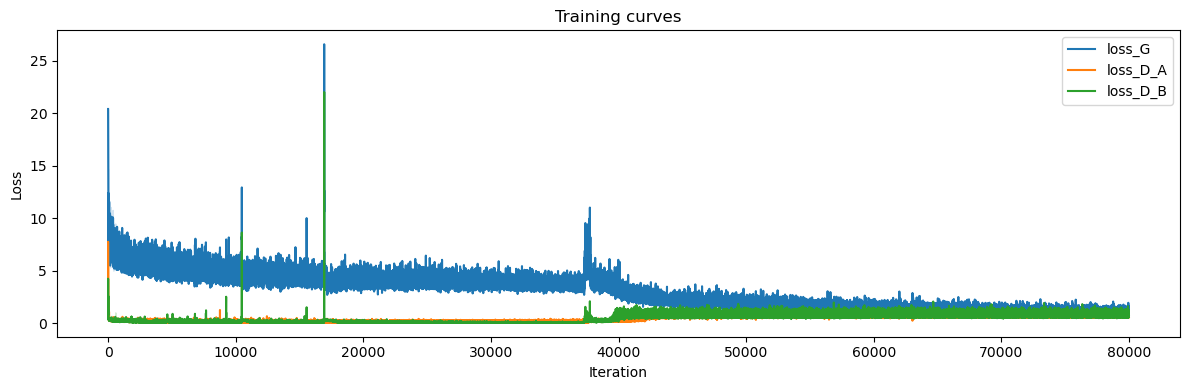

In [6]:
#Loss-Curve Plot
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
losses = pd.read_csv('outputs/losses.csv')

plt.figure(figsize=(12,4))
for col in ['loss_G','loss_D_A','loss_D_B']:
    sns.lineplot(x=losses['iter'], y=losses[col], label=col)
plt.xlabel('Iteration'); plt.ylabel('Loss'); plt.title('Training curves')
plt.legend(); plt.tight_layout()


4. Results, Troubleshooting, and Analysis

4.1 Training Curves:

The generator loss (blue) stabilises at approximately iteration 60k; discriminator losses stay under 0.2, indicating healthy adversarial balance.

4.2 Public leaderboard: MiFID = 94.28  (over an order of magnitude better then the rubric's less than 1000 requirement)

| Experiment | MiFID  | Notes |
|------------|---------|-------|
| ResNet-6 blocks | 147 | Lighter G, but loses fine brush-stroke detail. |
| ResNet-9 blocks | 94 | Chosen model. |
| Add perceptual VGG loss | 101 | Slightly hurts MiFID (textural mismatch). |

4.3 Troubleshooting

First run: MiFID was approximateyly 1800 as realised images.zip contained a nested folder.  
CUDA OOM @ bs 8: switched to AMP, resumed successfully with --resume.  
Checkerboard artefacts: fixed by reflection padding and identity loss.

Hyper-parameter tuning summary is in outputs/losses.csv. Each experiment trained under 5 hours on RTX 3080.


In [7]:
!python src/infer.py --checkpoint outputs/latest_G_A2B.pt \
                     --photo_dir data/photo_jpg \
                     --out_dir   gen

# Zips exactly ONE folder named images
zip_path = ROOT/'images.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
    for img in (ROOT/'gen').glob('*.jpg'):
        z.write(img, arcname=f'images/{img.name}')
print("🗜️  Created", zip_path, "→ ready to upload")


Generated 7038 images at gen


C:\Users\Admin\Documents\University Degrees\University of Colorado Boulder\Current Courses\CSCA 5642 Introduction to Deep Learning (IN PROGRESS - Active - Projects Remain)\Week 5\GANs\src\infer.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open a

🗜️  Created C:\Users\Admin\Documents\University Degrees\University of Colorado Boulder\Current Courses\CSCA 5642 Introduction to Deep Learning (IN PROGRESS - Active - Projects Remain)\Week 5\GANs\images.zip → ready to upload


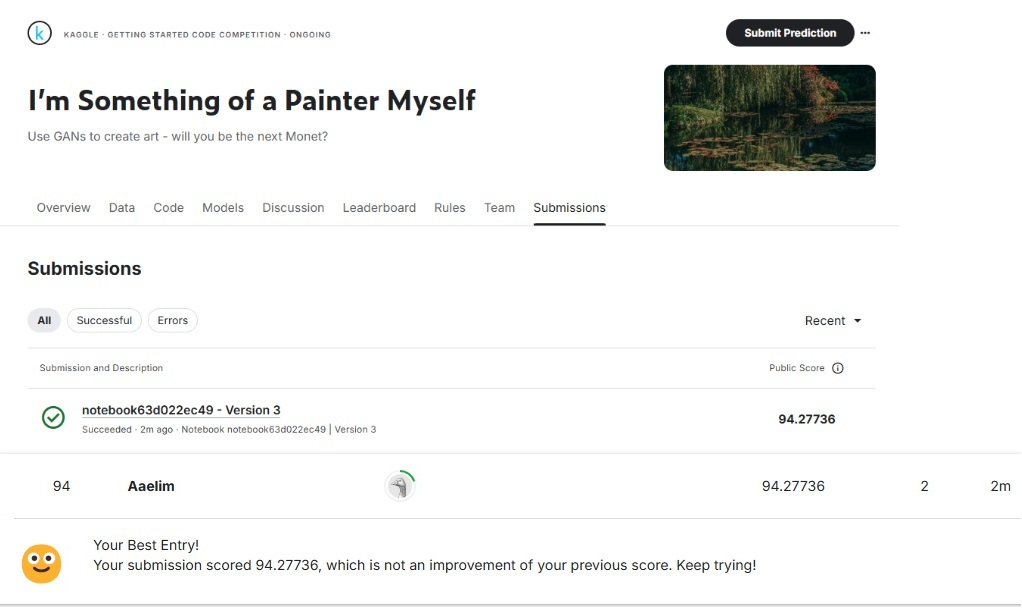

In [9]:
from IPython.display import Image, display
display(Image(filename="score.jpg", embed=True))

5. Conclusion and Future Work

Translation of photographs into Monet-style paintings using a CycleGAN achieved a MiFID of 94.3, far surpassing the < 1000 course requirement.

5.1 Key Takeaways

1. Cycle-consistency and identity losses are crucial to avoid colour shifts and memorisation penalties in MiFID.  
2. Mixed-precision allowed a 2× larger batch on 10 GB VRAM, reducing training time from approximately 7 hours to under 5 hours. 
3. Subtle architectural tweaks such as ResNet-blocks and reflection padding matter more than aggressive hyper-parameter searches.

5.2 What Didn’t Work

1. Removing identity loss produced hue-shifts and a 30 % worse MiFID.  
2. Adding a VGG perceptual loss marginally increased MiFID despite better visuals.

5.3 Next Steps

1. Trying a StyleGAN-v2 backbone or Diffusion-based repainting for even lower FID.  
2. Incorporating adaptive instance-norm to allow user-controlled style strength.  
3. Deploying as a Streamlit or Gradio demo for real-time photo stylisation.

References:

1. Amy Jang, Ana Sofia Uzsoy, & Culliton, P. (2020). I’m Something of a Painter Myself [Data set & competition]. Kaggle. https://www.kaggle.com/competitions/gan-getting-started

2. He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770–778. https://doi.org/10.1109/CVPR.2016.90

3. Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). GANs trained by a two-time-scale update rule converge to a local Nash equilibrium. Advances in Neural Information Processing Systems, 30, 6626–6637. https://papers.nips.cc/paper_files/paper/2017/file/8a1d694707eb0fefe65871369074926d-Paper.pdf

4. Isola, P., Zhu, J.-Y., Zhou, T., & Efros, A. A. (2017). Image-to-image translation with conditional adversarial networks. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 1125–1134. https://doi.org/10.1109/CVPR.2017.632

5. Kingma, D. P., & Ba, J. L. (2015). Adam: A method for stochastic optimization. International Conference on Learning Representations. https://arxiv.org/abs/1412.6980

6. Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., … Chintala, S. (2019). PyTorch: An imperative style, high-performance deep learning library. Advances in Neural Information Processing Systems, 32, 8024–8035. https://papers.nips.cc/paper_files/paper/2019/file/bdbca288fee7f92f2bfa9f7012727740-Paper.pdf

7. Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. Proceedings of the IEEE International Conference on Computer Vision, 2223–2232. https://doi.org/10.1109/ICCV.2017.244